# Chapter 5: Image Classification

## Very Important Reminder

In the book, the import that leads off this exercise starts with `from fastai2.vision.all ...` -- **that's incorrect**.  The correct import is `from fastai`, which you can see in [the clean version](https://github.com/fastai/fastbook/blob/master/clean/05_pet_breeds.ipynb) of the book.

Check the repo if there are any other bits that don't work.

Side note:  it would be really interesting to try re-implementing these things in PyTorch directly as I go; there is a lot of work on FastAI, and I'm not entirely sure I trust it as a library.

First, the usual boilerplate:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # The Answer to Life, the Universe, and Everything

Next, let's get the Pets data set:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/annotations')]

There are some cool utilities here:

In [3]:
(path / "images").ls()

(#7393) [Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/Siamese_87.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/chihuahua_126.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/german_shorthaired_97.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/Bombay_157.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/Bengal_12.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/japanese_chin_116.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/havanese_109.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/scottish_terrier_122.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_146.jpg'),Path('/home/aardvark/.fastai/data/oxford-iiit-pet/images/boxer_176.jpg')...]

In [4]:
fname = (path / "images").ls()[0]

In [5]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Siamese']

In [6]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

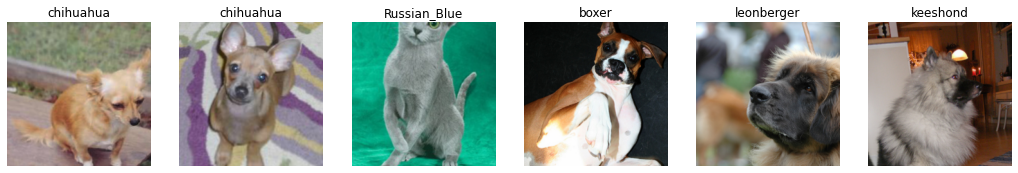

In [7]:
dls.show_batch(nrows=1, ncols=6)

In [8]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/aardvark/.fastai/data/oxford-iiit-pet/images/Bengal_49.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/aardvark/.fastai/data/oxford-iiit-pet/images/Bengal_49.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Settin

Okay, that looks generally all right. (Notably, we *don't* have the problem with the loader described on pg 193 of the book.)  Let's try building a simple model with `resnet34`.

In [9]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/aardvark/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.522075,0.296168,0.097429,09:44


epoch,train_loss,valid_loss,error_rate,time
0,0.498048,0.304913,0.094046,12:26
1,0.328781,0.235668,0.074425,11:21


So: that bit of training took 9.75 mins + 12.5 mins + 11.5 minutes, or 33.75 minutes in total.  By contrast: on Paperspace, it took ~ 6 mins -- but there's approximately a 10 minute startup time as well.

Since that took so long, let's save it before going on; this will let me pick up where I left off.

In [16]:
learn.save("chapter_5-resnet34")

Path('models/chapter_5-resnet34.pth')

In [18]:
!ls -l models

total 256056
-rw-r--r--. 1 aardvark aardvark 262198903 Nov 14 21:11 chapter_5-resnet34.pth


On with the rest!  (pg 194)

This section deals with cross-entropy loss.

Let's get one batch of data from our data loader.

In [19]:
x, y = dls.one_batch()

In [21]:
y

TensorCategory([ 4, 35, 17,  0, 15,  6,  3, 22, 22, 27, 11, 25,  5, 34, 31, 31, 30, 16,
        28,  7, 14,  1,  6,  1, 32, 30, 12,  2, 21, 21, 13, 36, 18, 10, 26, 34,
        12, 36, 14,  3, 24, 16, 31,  7, 31, 29, 15, 17, 22, 26, 26, 32,  3, 33,
        18,  2, 13, 20, 33, 19, 36, 27, 10, 32])

In [22]:
preds, _ = learn.get_preds(dl=[(x, y)])

In [23]:
preds[0]

TensorImage([1.1000e-05, 1.1479e-06, 8.7471e-07, 4.0963e-06, 9.9950e-01, 1.1201e-05,
        1.3862e-05, 2.7351e-05, 2.3578e-06, 3.5385e-04, 2.2332e-05, 1.9870e-06,
        1.5437e-06, 2.7185e-07, 3.0290e-07, 1.5292e-06, 1.8145e-07, 1.6871e-07,
        5.7241e-08, 1.0392e-06, 2.0304e-05, 1.2996e-06, 4.6113e-07, 3.3755e-07,
        2.5242e-06, 7.2292e-07, 1.2202e-07, 3.2244e-07, 1.7488e-07, 6.8577e-07,
        1.3764e-07, 3.6947e-07, 2.6600e-07, 1.5230e-05, 2.8450e-06, 8.5531e-07,
        1.1591e-06])

In [24]:
len(preds[0]), preds[0].sum()

(37, TensorImage(1.0000))

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

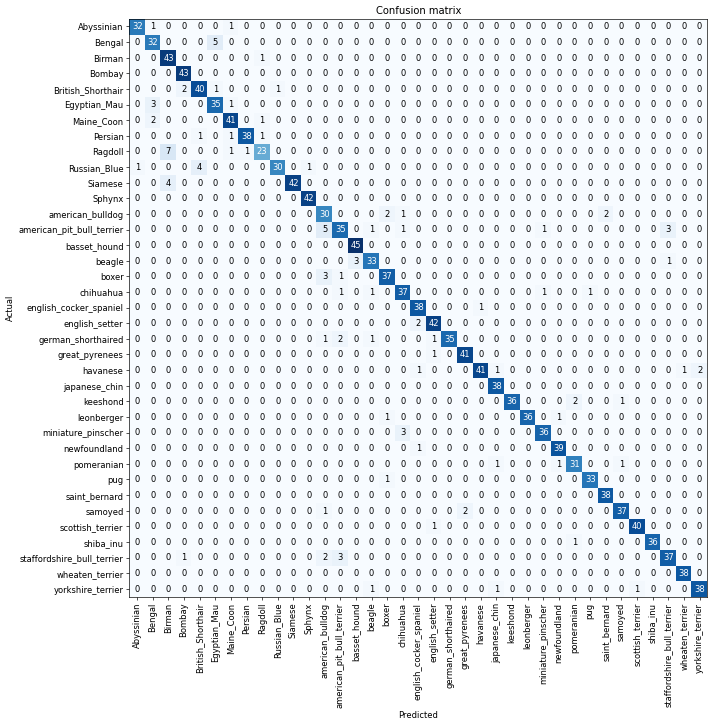

In [36]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 7),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]